In [11]:
import powerlaw
import os
import igraph as ig
import numpy as np

In [ ]:
def bipartite_cc_uu_prime(graph, u_id, u_prime_id):
    """
    Calculates the Jaccard index based clustering coefficient for a pair of vertices
    u and u' from the same set of nodes in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        u_id: The ID of the first vertex.
        u_prime_id: The ID of the second vertex.

    Returns:
        The Jaccard index (cc_u_u_prime) or 0 if union of neighbors is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")

    # Get neighbors of u and u'
    neighbors_u = set(graph.neighbors(u_id))
    neighbors_u_prime = set(graph.neighbors(u_prime_id))

    # Calculate intersection and union
    intersection = len(neighbors_u.intersection(neighbors_u_prime))
    union = len(neighbors_u.union(neighbors_u_prime))

    if union == 0:
        return 0.0
    return intersection / union

def local_bipartite_clustering_coefficient(graph, u_id, U_type_value=False):
    """
    Calculates the local clustering coefficient for a vertex u in a bipartite graph.
    The formula uses neighbors of neighbors (N(N(u))) that are of the same type as u.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute
               (e.g., True/False or 0/1 for the two partitions).
        u_id: The ID of the vertex for which to calculate the local clustering coefficient.
        U_type_value: The boolean value (True/False) that indicates the partition
                      to which node u belongs. All nodes in U should have this type.

    Returns:
        The local clustering coefficient for vertex u, or 0 if N(N(u)) is empty.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Ensure u_id is of the specified U_type_value
    if graph.vs[u_id]["type"] != U_type_value:
        raise ValueError(f"Vertex {u_id} does not belong to the specified partition U.")

    # Get neighbors of u
    neighbors_u = graph.neighbors(u_id)
    
    # Get neighbors of neighbors of u, filtering for nodes of the same type as u
    # These are the u' nodes in N(N(u)) that are in the same partition U
    nn_u = set()
    for v_neighbor_id in neighbors_u:
        for nn_id in graph.neighbors(v_neighbor_id):
            if graph.vs[nn_id]["type"] == U_type_value and nn_id != u_id: # Exclude u itself
                nn_u.add(nn_id)

    if not nn_u:
        return 0.0

    sum_cc_uu_prime = 0.0
    for u_prime_id in nn_u:
        sum_cc_uu_prime += bipartite_cc_uu_prime(graph, u_id, u_prime_id)

    return sum_cc_uu_prime / len(nn_u)

def average_local_bipartite_clustering_coefficient(graph, U_type_value=False):
    """
    Calculates the average local clustering coefficient for a set of nodes U
    in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        U_type_value: The boolean value (True/False) that indicates the partition
                      for which to calculate the average clustering coefficient.

    Returns:
        The average local clustering coefficient for the set U.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Get all vertices in set U
    U_vertices_ids = [v.index for v in graph.vs if v["type"] == U_type_value]

    if not U_vertices_ids:
        return 0.0

    sum_cc_u = 0.0
    for u_id in U_vertices_ids:
        sum_cc_u += local_bipartite_clustering_coefficient(graph, u_id, U_type_value)

    return sum_cc_u / len(U_vertices_ids)

In [42]:
def modified_bipartite_shortest_path(graph, source, target):
    """
    Calcula la longitud modificada del camino más corto entre dos nodos en un grafo bipartito.

    La modificación es la siguiente:
    - Si source y target son del mismo conjunto: longitud del camino / 2
    - Si source y target son de diferente conjunto: (longitud del camino + 1) / 2

    Args:
        graph: Un objeto igraph.Graph. Debe ser bipartito con un atributo de vértice 'type'.
        source: El ID del vértice de origen.
        target: El ID del vértice de destino.

    Returns:
        La longitud modificada del camino más corto como un entero, o -1 si no hay camino.
    """
    if not graph.is_bipartite():
        raise ValueError("El grafo debe ser bipartito.")
    if "type" not in graph.vs.attributes():
        raise ValueError("El grafo bipartito debe tener un atributo de vértice 'type'.")

    # Calcula la longitud del camino más corto estándar
    shortest_path_length = graph.get_shortest_paths(source, to=target, mode="out", weights=None)

    # get_shortest_paths devuelve una lista de listas de vértices, y la longitud es el número de aristas -1
    # Aquí estamos interesados en la longitud del camino (número de aristas)
    if not shortest_path_length or not shortest_path_length[0]:
        # No hay camino entre source y target
        return -1

    # La longitud de la lista de vértices en el camino es V+1, por lo que las aristas son V
    standard_length = len(shortest_path_length[0]) - 1

    if standard_length == -1: # Esto significa que source y target son el mismo nodo, distancia 0
        return 0

    # Determina si los nodos son del mismo tipo
    source_type = graph.vs[source]["type"]
    target_type = graph.vs[target]["type"]

    if source_type == target_type:
        # Mismo conjunto: longitud_modificada = longitud_estandar / 2
        return standard_length // 2  # Usamos // para asegurar una división entera
    else:
        # Diferente conjunto: longitud_modificada = (longitud_estandar + 1) / 2
        return (standard_length + 1) // 2

def average_modified_bipartite_shortest_path(graph):
    """
    Calcula la distancia promedio modificada entre todos los pares de vértices conectados
    en un grafo bipartito.

    Args:
        graph: Un objeto igraph.Graph. Debe ser bipartito con un atributo de vértice 'type'.

    Returns:
        La distancia promedio modificada.
    """
    if not graph.is_bipartite():
        raise ValueError("El grafo debe ser bipartito.")
    if "type" not in graph.vs.attributes():
        raise ValueError("El grafo bipartito debe tener un atributo de vértice 'type'.")

    total_modified_distance = 0
    connected_pairs_count = 0
    num_vertices = graph.vcount()

    # Iterar sobre todos los pares de vértices únicos (i, j) donde i < j
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            modified_dist = modified_bipartite_shortest_path(graph, i, j)
            if modified_dist != -1:  # Solo sumar si hay un camino
                total_modified_distance += modified_dist
                connected_pairs_count += 1

    if connected_pairs_count == 0:
        return 0.0  # O manejar como un error si el grafo está completamente desconectado

    return total_modified_distance / connected_pairs_count

In [43]:
# --- Prueba de average_modified_bipartite_shortest_path ---
print("--- Distancia Promedio Modificada ---")
avg_modified_dist = average_modified_bipartite_shortest_path(g)
print(f"Distancia promedio modificada para el grafo: {avg_modified_dist:.4f}")
print("-" * 30)

--- Distancia Promedio Modificada ---
Distancia promedio modificada para el grafo: 1.4286
------------------------------


In [72]:
# —————————— Helpers ——————————

def compute_power_law_bipartite(gb, type_n=1):
    """Calcula el alpha del bipartita"""
    fit = powerlaw.Fit(gb.degree(gb.vs.select(type=type_n)), discrete=True)
    return fit.alpha

def compute_power_law(g):
    """Calcula el alpha del proyectado"""
    fit = powerlaw.Fit(g.degree(), discrete=True)
    return fit.alpha

def compute_bip_metrics(gb, typen):
    """Calcula x1,x2,x3,x8,x9,γ_Ub del grafo bipartito."""
    x1 = len(gb.vs.select(type=0))
    x2 = len(gb.vs.select(type=1))
    x3 = gb.ecount()
    # x8 = average_local_bipartite_clustering_coefficient(gb, U_type_value=typen)
    x8 = 0.9
    try:
        #x9 = average_modified_bipartite_shortest_path(gb)
        x9 = 6
    except:
        x9 = np.inf
    x11 = compute_power_law_bipartite(gb, typen)
    return dict(x1=x1, x2=x2, x3=x3, x8=x8, x9=x9, x11=x11)

def compute_proj_metrics(gu):
    """Calcula x4,x5,x6,x7,x10,γ_U de la proyección."""
    x4 = gu.vcount()
    x5 = gu.ecount()
    x6 = len(gu.clusters())
    x7 = gu.transitivity_undirected()
    try:
        x10 = gu.average_path_length()
    except:
        x10 = np.inf
    x12 = compute_power_law(gu)
    return dict(x4=x4, x5=x5, x6=x6, x7=x7, x10=x10, x12=x12)

def evaluate_solution(bip, proj):
    """Dado bip y proj metrics, arma x, f, g."""
    # unimos diccionarios
    x = {
        **bip,
        **proj
    }
    # objetivos
    f = np.array([
        abs(x["x1"] - x["x4"]),
        (2*x["x5"]) / (x["x4"]*(x["x4"]-1)) if x["x4"]>1 else np.inf,
        x["x6"],
        1 - x["x7"],
        abs(x["x9"] - x["x10"]),
        abs(x["x11"] - x["x12"]),
        abs(x["x7"] - x["x8"])
    ])
    # restricciones g_i(x)<=0
    g = np.array([
        f[1] - x["x3"]/(x["x1"]*x["x2"]) if x["x1"]*x["x2"]>0 else np.inf,
    ])
    return dict(metrics=x, f=f, g=g, graph=proj)

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_front(sols):
    front = []
    for i, si in enumerate(sols):
        if any(np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"])
               for j, sj in enumerate(sols) if i!=j):
            continue
        front.append(si)
    return front

def crowding_distance(front):
    N, k = len(front), front[0]["f"].size
    F = np.array([s["f"] for s in front])
    dist = np.zeros(N)
    for m in range(k):
        idx = np.argsort(F[:,m])
        f_min, f_max = F[idx[0],m], F[idx[-1],m]
        dist[idx[0]] = dist[idx[-1]] = np.inf
        if f_max == f_min: continue
        for i in range(1, N-1):
            dist[idx[i]] += (F[idx[i+1],m] - F[idx[i-1],m]) / (f_max - f_min)
    return dist



In [67]:
gb.average_path_length()

5.635052745891971

In [73]:
bip_metrics = compute_bip_metrics(gb, 0)


Calculating best minimal value for power law fit


In [101]:
1-gu.transitivity_avglocal_undirected(mode="zero")

0.29004647553962104

In [90]:
# —————————— Flujo principal ——————————

# 1) Leer el único grafo bipartito
gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
# bip_metrics = compute_bip_metrics(gb, 0)

# 2) Escanear carpeta de proyecciones
proj_dir = "grafos"
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]

# 3) Calcular soluciones
solutions = []
for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    proj_metrics = compute_proj_metrics(gu)
    sol = evaluate_solution(bip_metrics, proj_metrics)
    sol["filename"] = fname  # <- Añadimos esta línea
    if is_feasible(sol):
        solutions.append(sol)




/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/533668733.py:4: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/533668733.py:15: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/1859855838.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  x6 = len(gu.clusters())
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [98]:
len(pareto_sorted)

12

In [91]:
# 4) Extraer Pareto y ordenar por crowding distance
pareto = pareto_front(solutions)
cd = crowding_distance(pareto)
pareto_sorted = [s for _, s in sorted(zip(-cd, pareto), key=lambda x: x[0])]

# 5) Salida: lista de grafos óptimos (proyecciones)
optimal_graphs = [s["graph"] for s in pareto_sorted]

# Ejemplo: imprimir nombres de archivo en orden óptimo
for sol in pareto_sorted:
    print(sol["metrics"]["x4"], sol["f"])



7493 [2.06800000e+03 3.85837958e-05 7.10700000e+03 9.82125128e-01
 2.69989524e+00 2.00205074e+00]
7518 [2.04300000e+03 1.67608029e-04 5.25900000e+03 9.32059251e-01
 1.62343436e+00 1.51972106e+00]
7514 [2.04700000e+03 7.11746521e-05 6.06100000e+03 9.63833250e-01
 1.28465797e+00 4.22511719e-01]
7518 [2.04300000e+03 3.28208796e-04 2.83700000e+03 7.68060496e-01
 9.12836411e-01 6.46797734e-01]
7501 [2.06000000e+03 1.12127272e-04 6.34100000e+03 9.52125004e-01
 2.29221962e+00 1.97529209e+00]
7517 [2.04400000e+03 1.74413957e-04 4.35500000e+03 8.74998318e-01
 1.36385999e+00 1.05988492e+00]
7517 [2.04400000e+03 2.20150274e-04 3.45900000e+03 8.86720616e-01
 2.06012420e+00 8.13992637e-01]
7518 [2.04300000e+03 2.56614403e-04 4.49800000e+03 8.85667445e-01
 1.91229081e+00 1.45169541e+00]
7518 [2.04300000e+03 2.56614403e-04 4.49800000e+03 8.85667445e-01
 1.91229081e+00 1.45169541e+00]
7518 [2.04300000e+03 1.67608029e-04 5.25900000e+03 9.32059251e-01
 1.62343436e+00 1.51972106e+00]
7518 [2.04300000e+03

In [92]:
print("Grafos óptimos ordenados por diversidad (crowding distance):")
for i, sol in enumerate(pareto_sorted, 1):
    print(f"{i:02d}. {sol['filename']} — f = {sol['f']}")

Grafos óptimos ordenados por diversidad (crowding distance):
01. amz_bot_weights_DF_alpha05.graphml — f = [2.06800000e+03 3.85837958e-05 7.10700000e+03 9.82125128e-01
 2.69989524e+00 2.00205074e+00]
02. amz_bot_hyper_DF_alpha1.graphml — f = [2.04300000e+03 1.67608029e-04 5.25900000e+03 9.32059251e-01
 1.62343436e+00 1.51972106e+00]
03. amz_bot_master_w_DF_alpha05.graphml — f = [2.04700000e+03 7.11746521e-05 6.06100000e+03 9.63833250e-01
 1.28465797e+00 4.22511719e-01]
04. amz_bot_master_w_DF_alpha15.graphml — f = [2.04300000e+03 3.28208796e-04 2.83700000e+03 7.68060496e-01
 9.12836411e-01 6.46797734e-01]
05. amz_bot_weights_DF_alpha15.graphml — f = [2.06000000e+03 1.12127272e-04 6.34100000e+03 9.52125004e-01
 2.29221962e+00 1.97529209e+00]
06. amz_bot_master_w_DF_alpha1.graphml — f = [2.04400000e+03 1.74413957e-04 4.35500000e+03 8.74998318e-01
 1.36385999e+00 1.05988492e+00]
07. amz_bot_master_DF_alpha05.graphml — f = [2.04400000e+03 2.20150274e-04 3.45900000e+03 8.86720616e-01
 2.0601

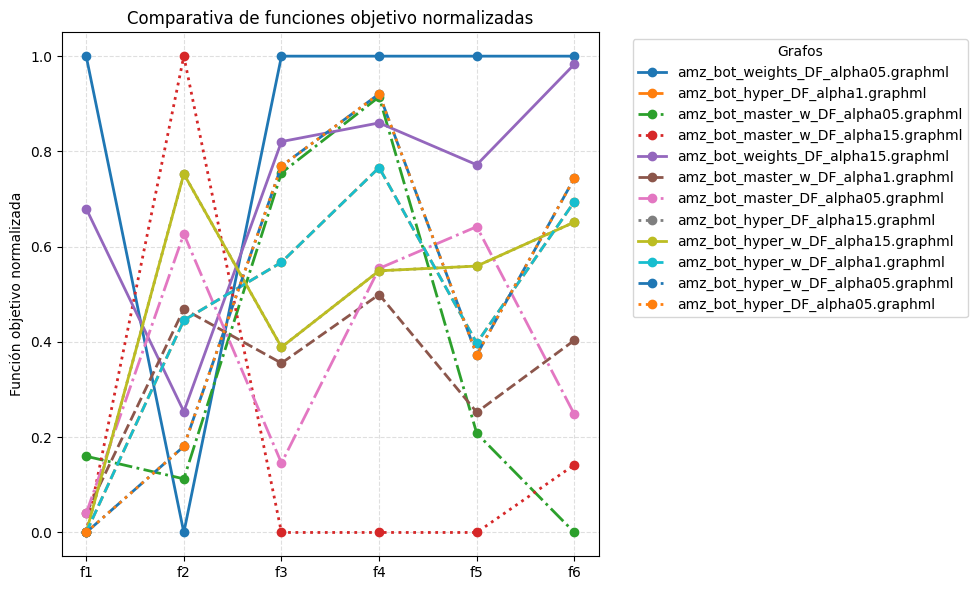

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Número máximo de grafos a graficar
N = len(pareto_sorted)
labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [105]:
proj_dir = "grafos2"
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]
proj_files

['amz_top_resall_DF_alpha1.graphml',
 'amz_top_master_w_DF_alpha15.graphml',
 'amz_top_master_w_DF_alpha05.graphml',
 'amz_top_hyper_DF_alpha1.graphml',
 'amz_top_master_w_DF_alpha2.graphml',
 'amz_top_master_DF_alpha05.graphml',
 'amz_top_master_DF_alpha15.graphml',
 'amz_top_master_DF_alpha1.graphml',
 'amz_top_weights_DF_alpha15.graphml',
 'amz_top_weights_DF_alpha05.graphml',
 'amz_top_weights_NC_alpha2.graphml',
 'amz_top_resall_DF_alpha05.graphml',
 'amz_top_resall_DF_alpha15.graphml',
 'amz_top_hyper_w_NC_alpha1.graphml',
 'amz_top_resall_w_DF_alpha1.graphml',
 'amz_top_master_DF_alpha2.graphml',
 'amz_top_resall_w_NC_alpha05.graphml',
 'amz_top_resall_w_NC_alpha15.graphml',
 'amz_top_weights_NC_alpha1.graphml',
 'amz_top_master_w_DF_alpha1.graphml',
 'amz_top_hyper_DF_alpha2.graphml',
 'amz_top_hyper_w_NC_alpha15.graphml',
 'amz_top_hyper_w_NC_alpha05.graphml',
 'amz_top_hyper_NC_alpha15.graphml',
 'amz_top_resall_DF_alpha2.graphml',
 'amz_top_hyper_NC_alpha05.graphml',
 'amz_t

In [102]:
# —————————— Flujo principal ——————————

# 1) Leer el único grafo bipartito
gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
# bip_metrics = compute_bip_metrics(gb, 0)

bip_metrics = compute_bip_metrics(gb, 1)


# 2) Escanear carpeta de proyecciones
proj_dir = "grafos2"
proj_files = [f for f in os.listdir(proj_dir)
              if f.endswith(".graphml") and f!="bipartito.graphml"]

# 3) Calcular soluciones
solutions = []
for fname in proj_files:
    gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
    proj_metrics = compute_proj_metrics(gu)
    sol = evaluate_solution(bip_metrics, proj_metrics)
    sol["filename"] = fname  # <- Añadimos esta línea
    if is_feasible(sol):
        solutions.append(sol)




/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/603364544.py:4: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML("binet-AMZ-Rw.graphml")
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/603364544.py:18: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gu = ig.Graph.Read_GraphML(os.path.join(proj_dir, fname))
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_52703/1859855838.py:32: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  x6 = len(gu.clusters())


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [106]:
# 4) Extraer Pareto y ordenar por crowding distance
pareto = pareto_front(solutions)
cd = crowding_distance(pareto)
pareto_sorted = [s for _, s in sorted(zip(-cd, pareto), key=lambda x: x[0])]

# 5) Salida: lista de grafos óptimos (proyecciones)
optimal_graphs = [s["graph"] for s in pareto_sorted]

# Ejemplo: imprimir nombres de archivo en orden óptimo
for sol in pareto_sorted:
    print(sol["metrics"]["x4"], sol["f"])



9514 [4.70000000e+01 2.96773668e-05 8.64200000e+03 9.82164864e-01
 3.10958469e-01 1.75315668e-01]
8345 [1.21600000e+03 4.77663007e-05 7.67600000e+03 9.85095484e-01
 2.11755748e+00 2.67460911e-01]
9557 [4.00000000e+00 3.60486067e-04 5.81000000e+03 8.67701108e-01
 6.58542996e-01 4.54901852e-01]
8691 [8.70000000e+02 2.56948745e-04 6.87000000e+03 9.33789817e-01
 1.00387123e+00 1.46294907e+00]
7518 [2.04300000e+03 4.19869436e-04 1.58200000e+03 8.82871791e-01
 2.42715742e-01 3.20571925e-01]
7518 [2.04300000e+03 1.36570815e-04 4.34500000e+03 9.83627339e-01
 1.78730923e+00 3.60632559e-01]
7518 [2.04300000e+03 2.68576294e-04 2.66000000e+03 9.36660911e-01
 5.84671101e-01 2.94540296e-01]


In [107]:
print("Grafos óptimos ordenados por diversidad (crowding distance):")
for i, sol in enumerate(pareto_sorted, 1):
    print(f"{i:02d}. {sol['filename']} — f = {sol['f']}")

Grafos óptimos ordenados por diversidad (crowding distance):
01. amz_top_master_w_DF_alpha05.graphml — f = [4.70000000e+01 2.96773668e-05 8.64200000e+03 9.82164864e-01
 3.10958469e-01 1.75315668e-01]
02. amz_top_weights_DF_alpha05.graphml — f = [1.21600000e+03 4.77663007e-05 7.67600000e+03 9.85095484e-01
 2.11755748e+00 2.67460911e-01]
03. amz_top_master_w_DF_alpha1.graphml — f = [4.00000000e+00 3.60486067e-04 5.81000000e+03 8.67701108e-01
 6.58542996e-01 4.54901852e-01]
04. amz_top_weights_DF_alpha1.graphml — f = [8.70000000e+02 2.56948745e-04 6.87000000e+03 9.33789817e-01
 1.00387123e+00 1.46294907e+00]
05. amz_top_resall_w_DF_alpha15.graphml — f = [2.04300000e+03 4.19869436e-04 1.58200000e+03 8.82871791e-01
 2.42715742e-01 3.20571925e-01]
06. amz_top_resall_w_DF_alpha05.graphml — f = [2.04300000e+03 1.36570815e-04 4.34500000e+03 9.83627339e-01
 1.78730923e+00 3.60632559e-01]
07. amz_top_resall_w_DF_alpha1.graphml — f = [2.04300000e+03 2.68576294e-04 2.66000000e+03 9.36660911e-01
 5.

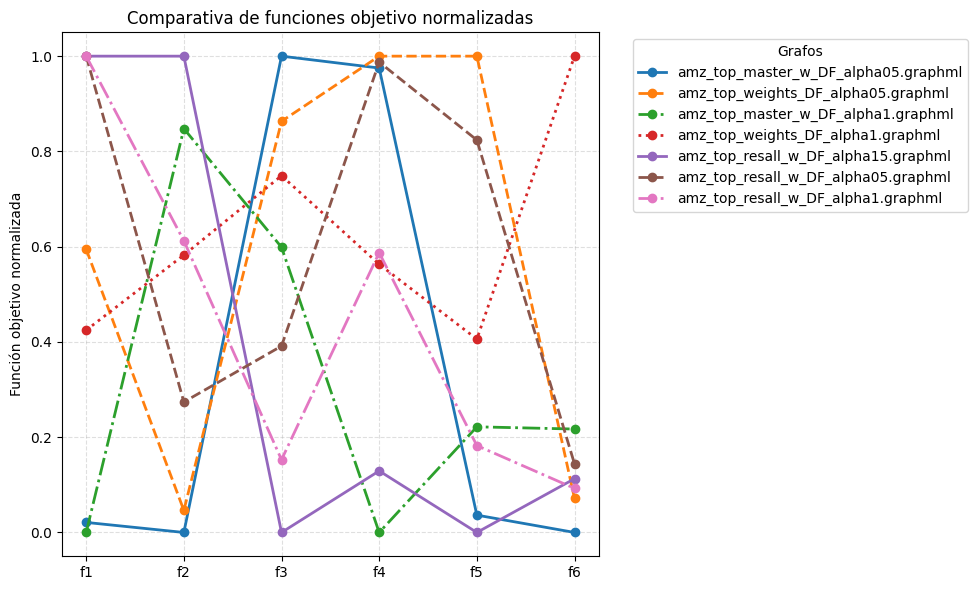

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Número máximo de grafos a graficar
N = len(pareto_sorted)
labels = [f"f{i+1}" for i in range(6)]  # nombres de funciones f1..f6

# Extraer vectores f y nombres de archivo
F = np.array([s["f"] for s in pareto_sorted[:N]])
names = [s["filename"] for s in pareto_sorted[:N]]

# Normalizar funciones objetivo columna por columna
F_norm = (F - F.min(axis=0)) / (F.max(axis=0) - F.min(axis=0) + 1e-8)

# Preparar figura
plt.figure(figsize=(10, 6))

# Colores y estilos variados
colors = plt.cm.tab10.colors
linestyles = ['-', '--', '-.', ':'] * 3

for i in range(N):
    plt.plot(
        labels,
        F_norm[i],
        label=names[i],
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2,
        marker='o'
    )

plt.ylabel("Función objetivo normalizada")
plt.title("Comparativa de funciones objetivo normalizadas")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Grafos", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
